# Reconhecimento Facial Usando SVD

Utilizaremos o banco de imagens ORL com 10 imagens de 40 indivíduos.

Inicialmente, os imports:

In [1]:
import numpy as np
import os
import cv2
import random
from scipy.linalg import eigh
import timeit
import matplotlib.pyplot as plt

Vamos ler as imagens em cada subdiretório e colocá-las numa matriz $A$.<br>
Devemos criar um vetor de classes $y$.

In [2]:
# working directory:
path = os.path.abspath("/home/thelmo/uece/cursos/analise_de_dados/jupyter/datasets/orl-faces")
dirs = os.listdir(path)
m = 112 * 92 # as imagens têm 112 * 92 pixels (Altura * Largura)
X = np.zeros(m) # uma linha de zeros
y = [] # lista de classes
img_id = [] # lista de identidade das imagens
d = 0
for d in dirs:
    wd = os.path.join(path,d)
    for _, _, files in os.walk(wd):
        for f in files:
            img = cv2.imread(os.path.join(wd,f), cv2.IMREAD_GRAYSCALE) / 255.0
            X = np.vstack((X,np.reshape(img,(1,m),order='F')))
            y.append(d)
            img_id.append(d+'-img'+f[:-4])
X = np.delete(X, 0, 0) # remove a primeira linha de zeros
print('Dimensões da matriz de dados:', np.shape(X))

Dimensões da matriz de dados: (400, 10304)


Agora, vamos compor as matrizes de treinamento e de teste:

In [4]:
# Criaremos ytest = np.zeros(80) para acompanhar os nomes das imagens
ntest = 2 # 2 de 10 imagens de cada indivíduo para teste
Xtest = np.zeros(m) # uma linha de zeros
ytest = []
img_id_test = []
Xtrain = np.copy(X)
ytrain = np.copy(y)
img_id_train = np.copy(img_id)
l = list(range(10))
for p in range(39,-1,-1): # para cada indivíduo
    random.shuffle(l)
    for k in l[0:2]:
        Xtest = np.vstack((Xtest,X[p*10 + k,:]))
        ytest.append(y[p*10 + k])
        img_id_test.append(img_id[p*10 + k])
        Xtrain = np.delete(Xtrain, p*10 + k, 0)
        ytrain = np.delete(ytrain, p*10 + k)
        img_id_train = np.delete(img_id_train, p*10 + k)
        
Xtest = np.delete(Xtest, 0, 0) # remove a primeira linha de zeros
Xtest = np.flip(Xtest, 0)
ytest = np.flip(ytest)  
img_id_test = np.flip(img_id_test)

print('Dimensões de Xtest =', np.shape(Xtest),'Dimensão de ytest =', np.shape(ytest))
print('Dimensões de Xtrain =', np.shape(Xtrain),'DImensão de ytrain =', np.shape(ytrain))

Dimensões de Xtest = (80, 10304) Dimensão de ytest = (80,)
Dimensões de Xtrain = (320, 10304) DImensão de ytrain = (320,)


Devemos agora calcular a matriz de covariância e sua decompoisção espectral.

In [5]:
M = np.mean(Xtrain, axis=0) # vetor de médias
Z = Xtrain - M # dados centralizados

# Devemos calcular a decomposição espectral de A = Zt*Z, mas...
#A = np.dot(Z.transpose(), Z)
#print(A.shape)
#w, Q = eigh(A)
#print('w =', np.sort(w)[::-1])

# ... mas o tempo de processamento é proibitivo.
# Se quisermos ver os 319 primeiros autovalores de A 
# devemos calculcar a decomposição espectral de A = Z*Zt:
A = np.dot(Z, Z.transpose())
print(A.shape)
start_time = timeit.default_timer()
w, Q = eigh(A)
elapsed = timeit.default_timer() - start_time
print('w =', np.sort(w)[::-1])
print('Tempo de processamento: {:6.2f} s'.format(elapsed))

(320, 320)
w = [1.36781452e+04 9.83420787e+03 5.48755061e+03 4.28837788e+03
 4.05668814e+03 2.66841298e+03 1.91265404e+03 1.80573523e+03
 1.52466523e+03 1.42272472e+03 1.15599227e+03 1.11644648e+03
 9.07000577e+02 8.26064828e+02 7.86217593e+02 7.39001784e+02
 6.85565245e+02 6.65883192e+02 5.78782661e+02 5.56704348e+02
 5.44792701e+02 5.11925914e+02 4.93928985e+02 4.42935345e+02
 4.06870258e+02 3.99565248e+02 3.81707901e+02 3.67760932e+02
 3.62395250e+02 3.50109415e+02 3.32773131e+02 3.21734821e+02
 3.07602462e+02 3.07081829e+02 2.92273711e+02 2.89686227e+02
 2.75261576e+02 2.65272830e+02 2.57381493e+02 2.50650571e+02
 2.42042299e+02 2.33762362e+02 2.30383070e+02 2.22342263e+02
 2.14582710e+02 2.07111439e+02 2.04785711e+02 2.03419163e+02
 2.00863870e+02 1.94485067e+02 1.85127915e+02 1.81576956e+02
 1.78125501e+02 1.73693789e+02 1.71335679e+02 1.69066767e+02
 1.60581295e+02 1.59070356e+02 1.57072990e+02 1.53574803e+02
 1.50674516e+02 1.48416210e+02 1.43367943e+02 1.41530394e+02
 1.392040

<b>Conseguimos os autovalores, mas e os autovetores? O que fazer???</b>

Vamos trabalhar com a <b>Decomposição de Valor Singular (SVD)</b>.

## Decomposição de Valor Singular - SVD

Calculemos a SVD da matriz $Xtrain$.

Primeiramente a SVD completa:

In [6]:
start_time = timeit.default_timer()
U, s, Vt = np.linalg.svd(Xtrain, full_matrices=True)
elapsed = timeit.default_timer() - start_time

print('U shape =', np.shape(U), 's length =', len(s), 'Vt shape =', np.shape(Vt))
print('Tempo de processamento: {:6.2f} s'.format(elapsed))

U shape = (320, 320) s length = 320 Vt shape = (10304, 10304)
Tempo de processamento:  17.41 s


Apesar de conseguirmos calcular a SVD completa em 10-20 segundos,<br>
não precisamos de todos os vetores singulares esquerdos de $X$,<br>
então utilizaremos sempre a <b>SVD reduzida</b>.

In [7]:
start_time = timeit.default_timer()
U, s, Vt = np.linalg.svd(Xtrain, full_matrices=False)
elapsed = timeit.default_timer() - start_time

print('U shape =', np.shape(U), 's length =', len(s), 'Vt shape =', np.shape(Vt))
print('Tempo de processamento: {:6.2f} s'.format(elapsed))

U shape = (320, 320) s length = 320 Vt shape = (320, 10304)
Tempo de processamento:   0.61 s


Bem melhor!

## Redução de Dimensionalidade

Agora, faremos a redução de dimensionalidade dos dados e<br>
procederemos com a classificação para o reconhecimento facial.

In [7]:
def reduced_coordinates(r):
    # Calcula as componentes principais:
    return U[:,0:r] * s[0:r], np.dot(Xtest, Vt[0:r,:].transpose())

In [9]:
r = 22
ntrains = np.shape(Xtrain)[0]
ntests = np.shape(Xtest)[0]

Ytrain, Ytest = reduced_coordinates(r)
count = 0
start_time = timeit.default_timer()
for i in range(ntests):
    dist = []
    for j in range(ntrains):
        dist = np.append(dist, np.linalg.norm(Ytest[i,:] - Ytrain[j,:]))
    index = np.argmin(dist)
    if ytrain[index] == ytest[i]:
        count += 1
elapsed = timeit.default_timer() - start_time
acc = count / ntests

print('Variabilidade acumulada até o {}-ésimo valor singular: {:4.1f} %.'\
      .format(r,(np.sum(s[0:r]**2) / np.sum(s**2))*100))
print('Acurácia = {:5.2f} %.'.format(acc*100))
print('Tempo de execução: {:6.2f} s.'.format(elapsed))

Variabilidade acumulada até o 22-ésimo valor singular: 97.1 %.
Acurácia = 98.75 %.
Tempo de execução:   0.27 s.


Vamos fazer um gráfico de variabilidade acumulada versus número de valores singulares<br>
e outro de acurácia versus número de valores singulares.

Text(0,0.5,'Variabilidade Acumulada')

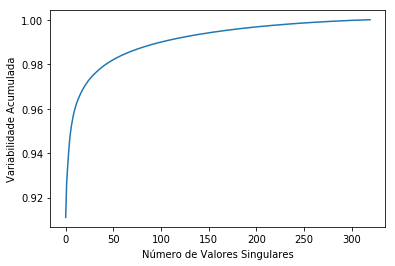

In [10]:
total_var = np.sum(s**2)
y_plot = np.cumsum(s**2) / total_var
x_plot = np.array(range(len(s)))

plt.plot(x_plot, y_plot)
plt.xlabel('Número de Valores Singulares')
plt.ylabel('Variabilidade Acumulada')

Text(0,0.5,'Acurácia')

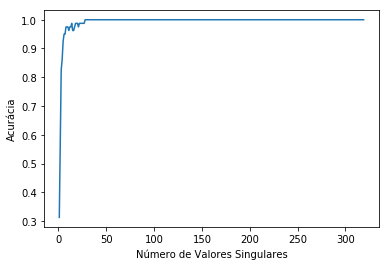

In [11]:
ntrains = np.shape(Xtrain)[0]
ntests = np.shape(Xtest)[0]

acc = []
for r in range(1,320):
    Ytrain, Ytest = reduced_coordinates(r)
    count = 0
    for i in range(ntests):
        dist = []
        for j in range(ntrains):
            dist = np.append(dist, np.linalg.norm(Ytest[i,:] - Ytrain[j,:]))
        index = np.argmin(dist)
        if ytrain[index] == ytest[i]:
            count += 1
    acc.append(count / ntests)
    
x_plot = list(range(1,320))
plt.plot(x_plot, acc)
plt.xlabel('Número de Valores Singulares')
plt.ylabel('Acurácia')

Vejamos uma parte do gráfico com mais detalhes.

In [ ]:
ntrains = np.shape(Xtrain)[0]
ntests = np.shape(Xtest)[0]

# Aqui devemos mudar os valores no range(a,b)
# dependendo do gráfico acima.
acc = []
for r in range(20,60):
    Ytrain, Ytest = reduced_coordinates(r)
    count = 0
    for i in range(ntests):
        dist = []
        for j in range(ntrains):
            dist = np.append(dist, np.linalg.norm(Ytest[i,:] - Ytrain[j,:]))
        index = np.argmin(dist)
        if ytrain[index] == ytest[i]:
            count += 1
    acc.append(count / ntests)
test_acc = np.mean(acc)
    
x_plot = list(range(20,60))
plt.plot(x_plot, acc)
plt.xlabel('Número de Valores Singulares')
plt.ylabel('Acurácia')

Vemos que, utilizando de $x_1$ a $x_2$ valores singulares, obtemos a acurácia máxima.<br>
Utilizar <b>mais</b> valores singulares, <b>diminui</b> a acurácia.

Por fim, vamos realizar uma validação cruzada com os dados.<br>
Usaremos o esquema <i>leave-one-out</i> por classe.

--> 10 --> 20 --> 30 --> 40 --> 50 --> 60 --> 70 --> 80 --> 90 --> 100 --> 110 --> 120 --> 130 --> 140 --> 150 --> 160 --> 170 --> 180 --> 190 --> 200 --> 210 --> 220 --> 230 --> 240 --> 250 --> 260 --> 270 --> 280 --> 290 --> 300 --> 310 --> 320 --> 330 --> 340 --> 350 
Tempo de execução =  343.53452211699914 s.


Text(0,0.5,'Acurácia')

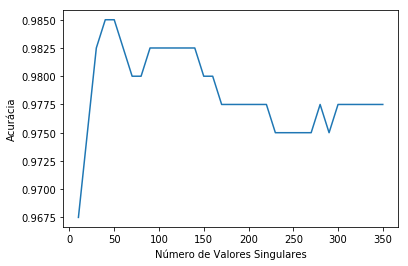

In [32]:
#r = 40
m = 112 * 92
ntrains = 360
ntests = 40
test_acc = []
start_time = timeit.default_timer()
for r in range(10,360,10):
    acc = []
    for k in range(10):
        Xtest = np.copy(X[k:400:10,:])
        ytest = np.copy(y[k:400:10])
        Xtrain = np.copy(X)
        ytrain = np.copy(y)
        for j in range(39,-1,-1):
            Xtrain = np.delete(Xtrain, j*10 + k, 0)
            ytrain = np.delete(ytrain, j*10 + k)
        U, s, Vt = np.linalg.svd(Xtrain, full_matrices=False)
        Ytrain, Ytest = reduced_coordinates(r)
        count = 0
        for i in range(ntests):
            dist = []
            for j in range(ntrains):
                dist = np.append(dist, np.linalg.norm(Ytest[i,:] - Ytrain[j,:]))
            index = np.argmin(dist)
            if ytrain[index] == ytest[i]:
                count += 1
        acc = np.append(acc, count / ntests)
        #print('--> k = {}: acurácia = {:5.2f}%'.format(k, acc[k]*100))
    test_acc = np.append(test_acc, np.mean(acc))
    print('-->', r, end=' ') 
elapsed = timeit.default_timer() - start_time
print('\nTempo de execução = ', elapsed, 's.')
#print('Acurácia Final = {:5.2f} %.'.format(test_acc*100))
x_plot = list(range(10,360,10))
plt.plot(x_plot, test_acc)
plt.xlabel('Número de Valores Singulares')
plt.ylabel('Acurácia')